# a)

# preprocess data


In [1]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 40.4 MB/s eta 0:00:00


In [2]:
from pathlib import Path
from warnings import filterwarnings
import pandas as pd
import numpy as np
from rdkit.Chem import Draw, PandasTools
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [7]:
df = pd.read_csv("BBBP.csv")
print(f"Shape of dataframe: {df.shape}\n")

Shape of dataframe: (2050, 4)



In [8]:
df.head()

,num,name,p_np,smiles
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...


In [9]:
df = df[["p_np", "smiles"]]

In [10]:
df.head()

,p_np,smiles
0,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...


In [11]:
def assess_two_letter_elements(df):

    # Search for unique characters in SMILES strings
    unique_chars = set(df.smiles.apply(list).sum())
    # Get upper and lower case letters only
    upper_chars = []
    lower_chars = []
    for entry in unique_chars:
        if entry.isalpha():
            if entry.isupper():
                upper_chars.append(entry)
            elif entry.islower():
                lower_chars.append(entry)
    print(f"Upper letter characters {sorted(upper_chars)}")
    print(f"Lower letter characters {sorted(lower_chars)}")

    # List of all possible periodic elements
    periodic_elements = [
        "Ac",
        "Al",
        "Am",
        "Sb",
        "Ar",
        "As",
        "At",
        "Ba",
        "Bk",
        "Be",
        "Bi",
        "Bh",
        "B",
        "Br",
        "Cd",
        "Ca",
        "Cf",
        "C",
        "Ce",
        "Cs",
        "Cl",
        "Cr",
        "Co",
        "Cn",
        "Cu",
        "Cm",
        "Ds",
        "Db",
        "Dy",
        "Es",
        "Er",
        "Eu",
        "Fm",
        "Fl",
        "F",
        "Fr",
        "Gd",
        "Ga",
        "Ge",
        "Au",
        "Hf",
        "Hs",
        "He",
        "Ho",
        "H",
        "In",
        "I",
        "Ir",
        "Fe",
        "Kr",
        "La",
        "Lr",
        "Pb",
        "Li",
        "Lv",
        "Lu",
        "Mg",
        "Mn",
        "Mt",
        "Md",
        "Hg",
        "Mo",
        "Mc",
        "Nd",
        "Ne",
        "Np",
        "Ni",
        "Nh",
        "Nb",
        "N",
        "No",
        "Og",
        "Os",
        "O",
        "Pd",
        "P",
        "Pt",
        "Pu",
        "Po",
        "K",
        "Pr",
        "Pm",
        "Pa",
        "Ra",
        "Rn",
        "Re",
        "Rh",
        "Rg",
        "Rb",
        "Ru",
        "Rf",
        "Sm",
        "Sc",
        "Sg",
        "Se",
        "Si",
        "Ag",
        "Na",
        "Sr",
        "S",
        "Ta",
        "Tc",
        "Te",
        "Ts",
        "Tb",
        "Tl",
        "Th",
        "Tm",
        "Sn",
        "Ti",
        "W",
        "U",
        "V",
        "Xe",
        "Yb",
        "Y",
        "Zn",
        "Zr",
        ]

    # The two_char_elements list contains all two letter elements
    # which can be generated by all possible combination of upper x lower characters
    # and are valid periodic elements.
    two_char_elements = []
    for upper in upper_chars:
        for lower in lower_chars:
            ch = upper + lower
            if ch in periodic_elements:
                two_char_elements.append(ch)

    # This list is then reduced to the subset of two-letter elements
    # that actually appear in the SMILES strings, specific to our data set.
    two_char_elements_smiles = set()
    for char in two_char_elements:
        if df.smiles.str.contains(char).any():
            two_char_elements_smiles.add(char)

    return two_char_elements_smiles

In [12]:
elements_found = assess_two_letter_elements(df)
print(f"\nTwo letter elements found in the data set: {sorted(elements_found)}")

Upper letter characters ['B', 'C', 'F', 'H', 'I', 'N', 'O', 'P', 'S']
Lower letter characters ['a', 'c', 'l', 'n', 'o', 'r', 's']

Two letter elements found in the data set: ['Br', 'Ca', 'Cl', 'Cn', 'Na', 'Sc']


In [13]:
replace_dict = {"Cl": "L", "Br": "R", "Se": "X", "@@": "Z"}

In [14]:
def preprocessing_data(df, replacement):

    # Create a new column having processed canonical SMILES
    df["processed_smiles"] = df["smiles"].copy()

    # Replace the two letter elements found with one character
    for pattern, repl in replacement.items():
        df["processed_smiles"] = df["processed_smiles"].str.replace(pattern, repl)

    unique_char = set(df.processed_smiles.apply(list).sum())
    return df, unique_char

In [15]:
# Calling function
df, unique_char = preprocessing_data(df, replace_dict)
df.head()

,p_np,smiles,processed_smiles
0,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12,[L].CC(C)NCC(O)COc1cccc2ccccc12
1,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCL)CCL
2,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...,Cc1onc(c2ccccc2L)c1C(=O)N[C@H]3[C@H]4SC(C)(C)[...


In [16]:
print(f"All unique characters found in the preprocessed data set:\n{sorted(unique_char)}")

All unique characters found in the preprocessed data set:
['#', '%', '(', ')', '+', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', '@', 'B', 'C', 'F', 'H', 'I', 'L', 'N', 'O', 'P', 'R', 'S', 'Z', '[', '\\', ']', 'a', 'c', 'n', 'o', 's']


# Plot the distribution of SMILES string lengths

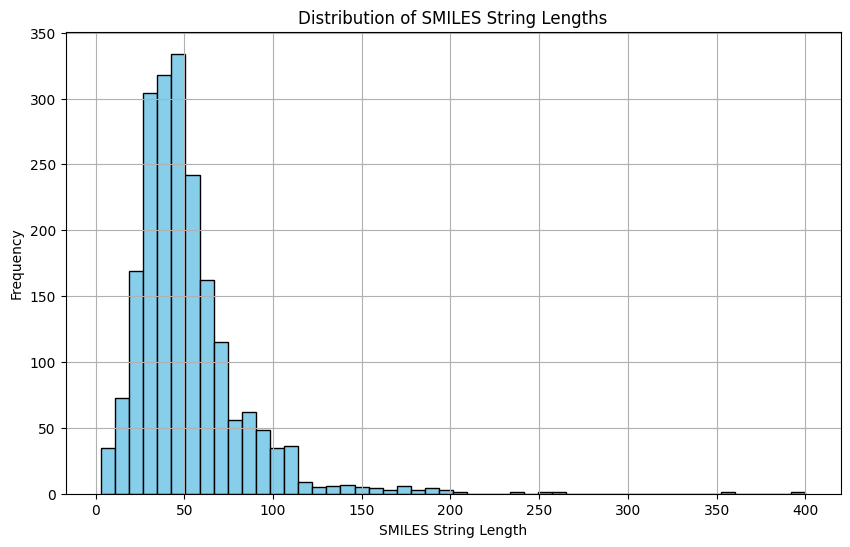

In [17]:
import matplotlib.pyplot as plt

# Calculate the length of each SMILES string
df['smiles_length'] = df['smiles'].apply(len)

plt.figure(figsize=(10, 6))
plt.hist(df['smiles_length'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of SMILES String Lengths')
plt.xlabel('SMILES String Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


# Obtain the variety of tokens and their frequency of occurrence

Tokens and their frequency:
C    30402
(    10491
)    10491
=     8034
c     6937
O     6208
@     4194
1     4128
N     3954
[     3479
]     3479
2     3370
3     2553
H     2392
4     1438
l      618
n      515
S      510
F      509
5      454
\      203
/      184
.      163
6      124
-      123
+      121
s       72
7       56
#       53
B       52
r       51
o       49
8       28
%       24
a       22
9       16
P       11
0        8
I        6
Name: smiles, dtype: int64


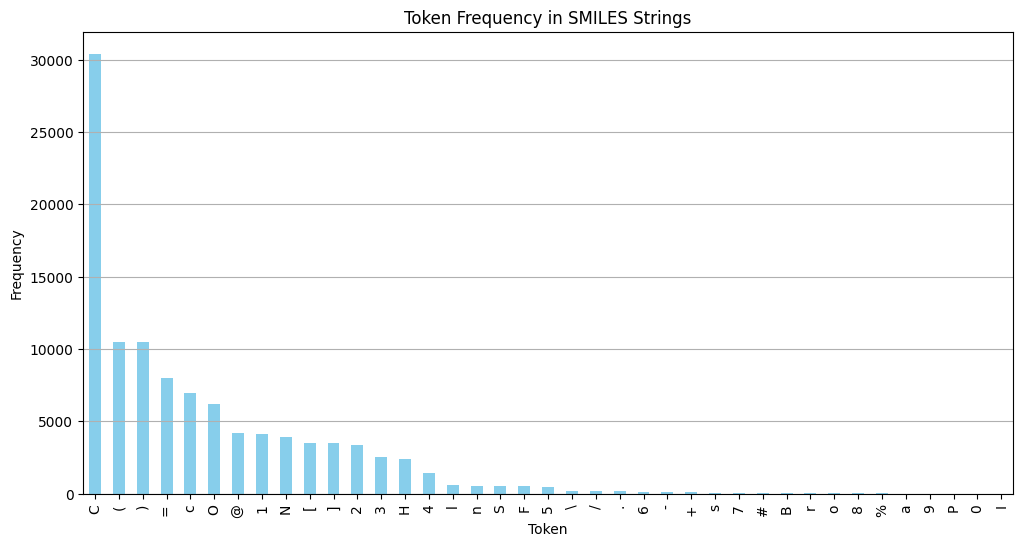

In [18]:
tokens_frequency = df['smiles'].apply(lambda x: list(x)).explode().value_counts()

# Display the tokens and their frequency
print("Tokens and their frequency:")
print(tokens_frequency)

# Plot the distribution of token frequencies
plt.figure(figsize=(12, 6))
tokens_frequency.plot(kind='bar', color='skyblue')
plt.title('Token Frequency in SMILES Strings')
plt.xlabel('Token')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()


In [ ]:
# Index of the longest SMILES string
longest_smiles = max(df["smiles"], key=len)
longest_smiles_index = df.smiles[df.smiles == longest_smiles].index.tolist()
print(f"Longest SMILES: {longest_smiles}")
print(f"Contains {len(longest_smiles)} characters, index in dataframe: {longest_smiles_index[0]}.")
smiles_maxlen = len(longest_smiles)

Longest SMILES: CCC(C)[C@H]1O[C@]2(CC[C@@H]1C)CC3C[C@@H](C\C=C(C)\[C@@H](O[C@H]4C[C@H](OC)[C@@H](OC5C[C@H](OC)[C@@H](O)[C@H](C)O5)[C@H](C)O4)[C@@H](C)/C=C/C=C/6CO[C@@H]7[C@H](O)C(=C[C@@H](C(=O)O3)[C@]67O)C)O2.CO[C@H]8CC(O[C@@H](C)[C@@H]8O)O[C@H]9[C@H](C)O[C@H](C[C@@H]9OC)O[C@H]/%10[C@@H](C)/C=C/C=C/%11CO[C@@H]%12[C@H](O)C(=C[C@@H](C(=O)OC%13C[C@@H](C\C=C%10C)O[C@@]%14(CC[C@H](C)[C@H](O%14)C(C)C)C%13)[C@]%11%12O)C
Contains 400 characters, index in dataframe: 826.


In [ ]:
# Index of the shortest SMILES string
shortest_smiles = min(df["smiles"], key=len)
shortest_smiles_index = df.smiles[df.smiles == shortest_smiles].index.tolist()
print(f"Shortest SMILES: {shortest_smiles}")
print(f"Contains {len(shortest_smiles)} characters, index in dataframe: {shortest_smiles_index[0]}.")

Shortest SMILES: CCO
Contains 3 characters, index in dataframe: 454.


In [ ]:
def smiles_encoder(smiles, max_len, unique_char):

    # create dictionary of the unique char data set
    smi2index = {char: index for index, char in enumerate(unique_char)}
    # one-hot encoding
    # zero padding to max_len
    smiles_matrix = np.zeros((len(unique_char), max_len))
    for index, char in enumerate(smiles):
        smiles_matrix[smi2index[char], index] = 1

    return smiles_matrix

In [ ]:
# Apply the function to the processed canonical SMILES strings
df["unique_char_ohe_matrix"] = df["processed_smiles"].apply(smiles_encoder, max_len=smiles_maxlen, unique_char=unique_char)
df.head()

,p_np,smiles,processed_smiles,unique_char_ohe_matrix
0,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12,[L].CC(C)NCC(O)COc1cccc2ccccc12,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCL)CCL,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...,Cc1onc(c2ccccc2L)c1C(=O)N[C@H]3[C@H]4SC(C)(C)[...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [ ]:
# Function to add padding after one-hot encoding
def later_padding(ohe_matrix, smiles_maxlen, unique_char):
  padded_matrix = np.pad(ohe_matrix,((0, smiles_maxlen - len(ohe_matrix)), (0, len(unique_char) - len(ohe_matrix[0]))), "constant",)
  return padded_matrix


# Function to add padding before one-hot encoding
def initial_padding(smiles, max_len):
    canonical_char = list(smiles)
    canonical_char_padded = np.pad(canonical_char, (0, max_len - len(canonical_char)), "constant")
    return canonical_char_padded

In [ ]:
# Use Scikit-learn implementation of one-hot encoding
def sklearn_one_hot_encoded_matrix(smiles, islaterpadding, isinitialpadding, smiles_maxlen, unique_char):
    # Integer encoding
    canonical_char = list(smiles)
    label_encoder = LabelEncoder()
    # Fit_transform function is used to first fit the data and then transform it
    integer_encoded = label_encoder.fit_transform(canonical_char)

    # If initial padding, add zeros to vector (columns in matrix)
    if isinitialpadding:
        integer_encoded = initial_padding(integer_encoded, smiles_maxlen)

    # One-hot encoding
    onehot_encoder = OneHotEncoder(sparse=False)
    # Reshape the integer encoded data
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

    # If later padding, add zeros to ohe matrix
    if islaterpadding:
        onehot_encoded = later_padding(onehot_encoded, smiles_maxlen, unique_char)

    onehot_encoded = onehot_encoded.transpose()

    # If initial padding, add zeros to rows
    if isinitialpadding:
        row_padding = np.zeros(shape=(len(unique_char) - len(onehot_encoded), smiles_maxlen))
        onehot_encoded = np.append(onehot_encoded, row_padding, axis=0)
    return onehot_encoded

In [ ]:
# Apply the function over the processed canonical SMILES strings
df["sklearn_ohe_matrix_later_padding"] = df["processed_smiles"].apply(
    sklearn_one_hot_encoded_matrix,
    islaterpadding=True,
    isinitialpadding=False,
    smiles_maxlen=smiles_maxlen,
    unique_char=unique_char,
)
df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_outp

,p_np,smiles,processed_smiles,unique_char_ohe_matrix,sklearn_ohe_matrix_later_padding
0,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12,[L].CC(C)NCC(O)COc1cccc2ccccc12,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,..."
1,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCL)CCL,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0,..."
2,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,..."
3,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,..."
4,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...,Cc1onc(c2ccccc2L)c1C(=O)N[C@H]3[C@H]4SC(C)(C)[...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,..."


In [ ]:
# Use keras implementation of one-hot encoding
def keras_one_hot_encoded_matrix(smiles, islaterpadding, smiles_maxlen, unique_char):

    # Integer encoding using Tokenizer
    input_smiles = smiles
    tokenizer = Tokenizer(char_level=True)
    tokenizer.fit_on_texts([input_smiles])
    integer_encoded = tokenizer.texts_to_sequences([input_smiles])[0]

    # One-hot encoding using to_categorical function
    encoded = to_categorical(integer_encoded)
    if islaterpadding:
        encoded = later_padding(encoded, smiles_maxlen, unique_char)
    encoded = encoded.transpose()
    return encoded

In [ ]:
# Apply the function over the Processed_canonical_smiles strings
df["keras_ohe_matrix_padding"] = df["processed_smiles"].apply(
    keras_one_hot_encoded_matrix,
    smiles_maxlen=smiles_maxlen,
    unique_char=unique_char,
    islaterpadding=True,
)
df.head()

,p_np,smiles,processed_smiles,unique_char_ohe_matrix,sklearn_ohe_matrix_later_padding,keras_ohe_matrix_padding
0,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12,[L].CC(C)NCC(O)COc1cccc2ccccc12,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCL)CCL,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...,Cc1onc(c2ccccc2L)c1C(=O)N[C@H]3[C@H]4SC(C)(C)[...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [ ]:
smiles_data = df["keras_ohe_matrix_padding"].values
#smiles_data = df["sklearn_ohe_matrix_later_padding"].values
labels = df["p_np"].values
print(smiles_data.shape)
print(smiles_data[0].shape)

reshaped_smiles_data = np.stack(smiles_data).reshape((2050, -1))
print(reshaped_smiles_data.shape)

(2050,)
(40, 400)
(2050, 16000)


# b) FC Network (baseline)

In [ ]:
# Split the data into training and testing sets
train_smiles, test_smiles, train_labels, test_labels = train_test_split(reshaped_smiles_data, labels, train_size=0.8, random_state=42)

# Convert data to PyTorch tensors
train_smiles_tensor = torch.FloatTensor(train_smiles)
train_labels_tensor = torch.FloatTensor(train_labels)
test_smiles_tensor = torch.FloatTensor(test_smiles)
test_labels_tensor = torch.FloatTensor(test_labels)

# Define the Neural Network
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

# Initialize the model
input_size = train_smiles_tensor.shape[1]
hidden_size = 128
output_size = 1  # Binary classification (p_np)
model = SimpleNN(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 10
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(train_smiles_tensor)
    loss = criterion(outputs, train_labels_tensor.view(-1, 1))

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Convert outputs to binary predictions (0 or 1)
    train_predictions = (outputs >= 0.5).float()

    # Calculate accuracy
    train_accuracy = torch.sum(train_predictions == train_labels_tensor.view(-1, 1)).item() / len(train_labels)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}, Training Accuracy: {train_accuracy * 100:.2f}%')

# Evaluate the model on the test set
with torch.no_grad():
    test_outputs = model(test_smiles_tensor)
    test_loss = criterion(test_outputs, test_labels_tensor.view(-1, 1))
    print(f'Test Loss: {test_loss.item()}')

    # Convert outputs to binary predictions (0 or 1)
    test_predictions = (test_outputs >= 0.5).float()

    # Calculate accuracy
    test_accuracy = torch.sum(test_predictions == test_labels_tensor.view(-1, 1)).item() / len(test_labels)

    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')



Epoch [1/10], Loss: 0.6969994306564331, Training Accuracy: 26.34%
Epoch [2/10], Loss: 0.6637711524963379, Training Accuracy: 77.32%
Epoch [3/10], Loss: 0.634819507598877, Training Accuracy: 77.80%
Epoch [4/10], Loss: 0.6077398061752319, Training Accuracy: 77.99%
Epoch [5/10], Loss: 0.5830008387565613, Training Accuracy: 78.11%
Epoch [6/10], Loss: 0.560706615447998, Training Accuracy: 78.35%
Epoch [7/10], Loss: 0.5406423807144165, Training Accuracy: 78.60%
Epoch [8/10], Loss: 0.5224884152412415, Training Accuracy: 78.84%
Epoch [9/10], Loss: 0.5058656930923462, Training Accuracy: 79.09%
Epoch [10/10], Loss: 0.490485817193985, Training Accuracy: 79.45%
Test Loss: 0.49027150869369507
Test Accuracy: 79.76%


# c) LSTM

# Simple LSTM

In [ ]:
reshaped_smiles_data = np.stack(smiles_data)
sequence_length = 40

# Split the data into training and testing sets
train_smiles, test_smiles, train_labels, test_labels = train_test_split(reshaped_smiles_data, labels, train_size=0.8, random_state=42)

# Convert data to PyTorch tensors
train_smiles_tensor = torch.FloatTensor(train_smiles)
train_labels_tensor = torch.FloatTensor(train_labels)
test_smiles_tensor = torch.FloatTensor(test_smiles)
test_labels_tensor = torch.FloatTensor(test_labels)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, sequence_length):
        super(LSTMModel, self).__init__()
        self.flatten = nn.Flatten()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        flattened = self.flatten(x)
        lstm_out, _ = self.lstm(flattened.unsqueeze(1))
        out = self.fc1(lstm_out[:, -1, :])
        out = self.sigmoid(out)  # Apply sigmoid activation
        return out

# Initialize the model
hidden_size = 128
output_size = 1
model = LSTMModel(input_size, hidden_size, output_size, sequence_length)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 10

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(train_smiles_tensor)
    outputs = outputs.squeeze()  # Squeeze the output to match the shape of train_labels_tensor
    loss = criterion(outputs, train_labels_tensor)

    # Convert outputs to binary predictions (0 or 1)
    train_predictions = (outputs >= 0.5).float()

    # Calculate accuracy
    train_accuracy = torch.sum(train_predictions == train_labels_tensor).item() / len(train_labels)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}, Training Accuracy: {train_accuracy * 100:.2f}%')

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


# Evaluate the model on the test set
with torch.no_grad():
    test_outputs = model(test_smiles_tensor)
    test_loss = criterion(test_outputs, test_labels_tensor.view(-1, 1))
    print(f'Test Loss: {test_loss.item()}')

    # Convert outputs to binary predictions (0 or 1)
    test_predictions = (test_outputs >= 0.5).float()

    # Calculate accuracy
    test_accuracy = torch.sum(test_predictions == test_labels_tensor.view(-1, 1)).item() / len(test_labels)

    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


Epoch [1/10], Loss: 0.6761369109153748, Training Accuracy: 72.93%
Epoch [2/10], Loss: 0.6578059792518616, Training Accuracy: 76.77%
Epoch [3/10], Loss: 0.640713632106781, Training Accuracy: 77.01%
Epoch [4/10], Loss: 0.6246157288551331, Training Accuracy: 77.38%
Epoch [5/10], Loss: 0.6093418598175049, Training Accuracy: 77.74%
Epoch [6/10], Loss: 0.5947810411453247, Training Accuracy: 77.80%
Epoch [7/10], Loss: 0.5808709263801575, Training Accuracy: 77.93%
Epoch [8/10], Loss: 0.5675864815711975, Training Accuracy: 77.99%
Epoch [9/10], Loss: 0.5549262762069702, Training Accuracy: 78.05%
Epoch [10/10], Loss: 0.5428981781005859, Training Accuracy: 78.29%
Test Loss: 0.541196346282959
Test Accuracy: 78.05%


# More Copmlex LSTM

In [ ]:
class LSTMModelWithFC(nn.Module):
    def __init__(self, input_size, hidden_size, fc_size, output_size, sequence_length):
        super(LSTMModelWithFC, self).__init__()
        self.flatten = nn.Flatten()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, fc_size)  # Additional fully connected layer
        self.relu = nn.ReLU()  # Adding a ReLU activation function
        self.fc2 = nn.Linear(fc_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        flattened = self.flatten(x)
        lstm_out, _ = self.lstm(flattened.unsqueeze(1))
        fc_out = self.fc1(lstm_out[:, -1, :])
        fc_out = self.relu(fc_out)  # Applying ReLU activation
        out = self.fc2(fc_out)
        out = self.sigmoid(out)  # Apply sigmoid activation
        return out


# Initialize the model with an additional FC layer
fc_size = 64  # Adjust the size of the FC layer as needed
model_with_fc = LSTMModelWithFC(input_size, hidden_size, fc_size, output_size, sequence_length)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model_with_fc.parameters(), lr=0.001)

# Training the model
num_epochs = 10

for epoch in range(num_epochs):
    # Forward pass
    outputs = model_with_fc(train_smiles_tensor)
    outputs = outputs.squeeze()
    loss = criterion(outputs, train_labels_tensor)

    # Convert outputs to binary predictions (0 or 1)
    train_predictions = (outputs >= 0.5).float()

    # Calculate accuracy
    train_accuracy = torch.sum(train_predictions == train_labels_tensor).item() / len(train_labels)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}, Training Accuracy: {train_accuracy * 100:.2f}%')

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Evaluate the model on the test set
with torch.no_grad():
    test_outputs = model_with_fc(test_smiles_tensor)
    test_loss = criterion(test_outputs, test_labels_tensor.view(-1, 1))
    print(f'Test Loss: {test_loss.item()}')

    # Convert outputs to binary predictions (0 or 1)
    test_predictions = (test_outputs >= 0.5).float()

    # Calculate accuracy
    test_accuracy = torch.sum(test_predictions == test_labels_tensor.view(-1, 1)).item() / len(test_labels)

    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


Epoch [1/10], Loss: 0.6579861640930176, Training Accuracy: 76.34%
Epoch [2/10], Loss: 0.650336742401123, Training Accuracy: 76.34%
Epoch [3/10], Loss: 0.6425312161445618, Training Accuracy: 76.40%
Epoch [4/10], Loss: 0.6342831254005432, Training Accuracy: 76.40%
Epoch [5/10], Loss: 0.6254577040672302, Training Accuracy: 76.46%
Epoch [6/10], Loss: 0.6160052418708801, Training Accuracy: 76.59%
Epoch [7/10], Loss: 0.6058717966079712, Training Accuracy: 76.83%
Epoch [8/10], Loss: 0.5950599312782288, Training Accuracy: 77.26%
Epoch [9/10], Loss: 0.5836232900619507, Training Accuracy: 77.32%
Epoch [10/10], Loss: 0.5716543197631836, Training Accuracy: 77.44%
Test Loss: 0.5635949373245239
Test Accuracy: 77.32%


# d) BILSTM

# Simple BILSTM

In [ ]:
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, sequence_length):
        super(BiLSTMModel, self).__init__()
        self.flatten = nn.Flatten()
        self.bilstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_size * 2, output_size)  # Adjusted input size for bidirectional
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        flattened = self.flatten(x)
        bilstm_out, _ = self.bilstm(flattened.unsqueeze(1))
        out = self.fc1(bilstm_out[:, -1, :])
        out = self.sigmoid(out)
        return out

# Initialize the BiLSTM model
hidden_size = 128
output_size = 1
bi_lstm_model = BiLSTMModel(input_size, hidden_size, output_size, sequence_length)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(bi_lstm_model.parameters(), lr=0.001)

# Training the BiLSTM model
num_epochs = 10

for epoch in range(num_epochs):
    # Forward pass
    outputs = bi_lstm_model(train_smiles_tensor)
    outputs = outputs.squeeze()  # Squeeze the output to match the shape of train_labels_tensor
    loss = criterion(outputs, train_labels_tensor)

    # Convert outputs to binary predictions (0 or 1)
    train_predictions = (outputs >= 0.5).float()

    # Calculate accuracy
    train_accuracy = torch.sum(train_predictions == train_labels_tensor).item() / len(train_labels)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}, Training Accuracy: {train_accuracy * 100:.2f}%')

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Evaluate the BiLSTM model on the test set
with torch.no_grad():
    test_outputs = bi_lstm_model(test_smiles_tensor)
    test_loss = criterion(test_outputs, test_labels_tensor.view(-1, 1))
    print(f'Test Loss: {test_loss.item()}')

    # Convert outputs to binary predictions (0 or 1)
    test_predictions = (test_outputs >= 0.5).float()

    # Calculate accuracy
    test_accuracy = torch.sum(test_predictions == test_labels_tensor.view(-1, 1)).item() / len(test_labels)

    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


Epoch [1/10], Loss: 0.6746904850006104, Training Accuracy: 75.49%
Epoch [2/10], Loss: 0.6512017846107483, Training Accuracy: 77.38%
Epoch [3/10], Loss: 0.62954181432724, Training Accuracy: 77.56%
Epoch [4/10], Loss: 0.6093504428863525, Training Accuracy: 77.68%
Epoch [5/10], Loss: 0.5903926491737366, Training Accuracy: 77.93%
Epoch [6/10], Loss: 0.5725609064102173, Training Accuracy: 77.93%
Epoch [7/10], Loss: 0.5558314919471741, Training Accuracy: 78.05%
Epoch [8/10], Loss: 0.5402197241783142, Training Accuracy: 78.23%
Epoch [9/10], Loss: 0.5257444381713867, Training Accuracy: 78.48%
Epoch [10/10], Loss: 0.5124002695083618, Training Accuracy: 78.66%
Test Loss: 0.514071524143219
Test Accuracy: 78.29%


# More Complex BILSTM

In [ ]:
class BiLSTMModelWithFC(nn.Module):
    def __init__(self, input_size, hidden_size, fc_size, output_size, sequence_length):
        super(BiLSTMModelWithFC, self).__init__()
        self.flatten = nn.Flatten()
        self.bilstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_size * 2, fc_size)  # Additional fully connected layer for bidirectional
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fc_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        flattened = self.flatten(x)
        bilstm_out, _ = self.bilstm(flattened.unsqueeze(1))
        fc_out = self.fc1(bilstm_out[:, -1, :])
        fc_out = self.relu(fc_out)
        out = self.fc2(fc_out)
        out = self.sigmoid(out)
        return out

# Initialize the model with an additional FC layer
fc_size = 64  # Adjust the size of the FC layer as needed
bilstm_model_with_fc = BiLSTMModelWithFC(input_size, hidden_size, fc_size, output_size, sequence_length)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(bilstm_model_with_fc.parameters(), lr=0.001)

# Training the model
num_epochs = 10

for epoch in range(num_epochs):
    # Forward pass
    outputs = bilstm_model_with_fc(train_smiles_tensor)
    outputs = outputs.squeeze()
    loss = criterion(outputs, train_labels_tensor)

    # Convert outputs to binary predictions (0 or 1)
    train_predictions = (outputs >= 0.5).float()

    # Calculate accuracy
    train_accuracy = torch.sum(train_predictions == train_labels_tensor).item() / len(train_labels)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}, Training Accuracy: {train_accuracy * 100:.2f}%')

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Evaluate the model on the test set
with torch.no_grad():
    test_outputs = bilstm_model_with_fc(test_smiles_tensor)
    test_loss = criterion(test_outputs, test_labels_tensor.view(-1, 1))
    print(f'Test Loss: {test_loss.item()}')

    # Convert outputs to binary predictions (0 or 1)
    test_predictions = (test_outputs >= 0.5).float()

    # Calculate accuracy
    test_accuracy = torch.sum(test_predictions == test_labels_tensor.view(-1, 1)).item() / len(test_labels)

    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


Epoch [1/10], Loss: 0.7260690331459045, Training Accuracy: 23.66%
Epoch [2/10], Loss: 0.7138615250587463, Training Accuracy: 23.66%
Epoch [3/10], Loss: 0.7028472423553467, Training Accuracy: 28.05%
Epoch [4/10], Loss: 0.6911590695381165, Training Accuracy: 52.38%
Epoch [5/10], Loss: 0.6777369976043701, Training Accuracy: 70.00%
Epoch [6/10], Loss: 0.6623612642288208, Training Accuracy: 74.27%
Epoch [7/10], Loss: 0.6450866460800171, Training Accuracy: 75.55%
Epoch [8/10], Loss: 0.6261075735092163, Training Accuracy: 76.95%
Epoch [9/10], Loss: 0.6058184504508972, Training Accuracy: 77.74%
Epoch [10/10], Loss: 0.5848682522773743, Training Accuracy: 78.05%
Test Loss: 0.5694229602813721
Test Accuracy: 78.05%


# e) Cross Validation

# LSTM, Cross Validation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import cross_val_score, KFold
from sklearn.base import BaseEstimator, ClassifierMixin

smiles_tensor = torch.FloatTensor(reshaped_smiles_data)
labels_tensor = torch.FloatTensor(labels)



# Wrapper class for PyTorch model to work with cross_val_score
class PyTorchWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        print("new fold")
        # Train the model
        criterion = nn.BCELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=0.001)

        num_epochs = 10
        for epoch in range(num_epochs):
            # Forward pass
            outputs = self.model(X)
            loss = criterion(outputs, y.view(-1, 1))

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

        return self

    def predict(self, X):
        # Convert outputs to binary predictions (0 or 1)
        predictions = (self.model(X) >= 0.5).float()
        return predictions

# Initialize the model
hidden_size = 128
output_size = 1  # Binary classification (p_np)
lstm_model = LSTMModel(input_size, hidden_size, output_size, sequence_length)

# Use cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
pytorch_model = PyTorchWrapper(lstm_model)
accuracies = cross_val_score(pytorch_model, smiles_tensor, labels_tensor, cv=kf, scoring='accuracy')

# Print the accuracies for each fold
for fold, accuracy in enumerate(accuracies, 1):
    print(f'Fold {fold} Accuracy: {accuracy * 100:.2f}%')

# Report the final accuracy
print(f'Final Accuracy: {accuracies.mean() * 100:.2f}%')


new fold
Epoch [1/10], Loss: 0.7178749442100525
Epoch [2/10], Loss: 0.7001441121101379
Epoch [3/10], Loss: 0.6833022832870483
Epoch [4/10], Loss: 0.6671201586723328
Epoch [5/10], Loss: 0.6514408588409424
Epoch [6/10], Loss: 0.6361801624298096
Epoch [7/10], Loss: 0.6213139295578003
Epoch [8/10], Loss: 0.6068609356880188
Epoch [9/10], Loss: 0.5928665995597839
Epoch [10/10], Loss: 0.5793891549110413
new fold
Epoch [1/10], Loss: 0.7174617648124695
Epoch [2/10], Loss: 0.6991494297981262
Epoch [3/10], Loss: 0.6817539930343628
Epoch [4/10], Loss: 0.6650567054748535
Epoch [5/10], Loss: 0.6488989591598511
Epoch [6/10], Loss: 0.6331926584243774
Epoch [7/10], Loss: 0.6179123520851135
Epoch [8/10], Loss: 0.6030777096748352
Epoch [9/10], Loss: 0.5887354612350464
Epoch [10/10], Loss: 0.5749444961547852
new fold
Epoch [1/10], Loss: 0.7180846929550171
Epoch [2/10], Loss: 0.7001434564590454
Epoch [3/10], Loss: 0.6830558180809021
Epoch [4/10], Loss: 0.6666058897972107
Epoch [5/10], Loss: 0.6506394743919

# BILSTM Cross Validation

In [ ]:
# Initialize the model
hidden_size = 128
output_size = 1  # Binary classification (p_np)
bilstm_model = BiLSTMModel(input_size, hidden_size, output_size, sequence_length)

# Use cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
pytorch_model = PyTorchWrapper(bilstm_model)
accuracies = cross_val_score(pytorch_model, smiles_tensor, labels_tensor, cv=kf, scoring='accuracy')

# Print the accuracies for each fold
for fold, accuracy in enumerate(accuracies, 1):
    print(f'Fold {fold} Accuracy: {accuracy * 100:.2f}%')

# Report the final accuracy
print(f'Final Accuracy: {accuracies.mean() * 100:.2f}%')


new fold
Epoch [1/10], Loss: 0.6866397261619568
Epoch [2/10], Loss: 0.6623302102088928
Epoch [3/10], Loss: 0.6398507952690125
Epoch [4/10], Loss: 0.6188074350357056
Epoch [5/10], Loss: 0.5990023612976074
Epoch [6/10], Loss: 0.5803751945495605
Epoch [7/10], Loss: 0.5629410743713379
Epoch [8/10], Loss: 0.5467404723167419
Epoch [9/10], Loss: 0.5318021178245544
Epoch [10/10], Loss: 0.5181175470352173
new fold
Epoch [1/10], Loss: 0.6867480278015137
Epoch [2/10], Loss: 0.6615623831748962
Epoch [3/10], Loss: 0.6383185386657715
Epoch [4/10], Loss: 0.6166063547134399
Epoch [5/10], Loss: 0.5962082743644714
Epoch [6/10], Loss: 0.5770485401153564
Epoch [7/10], Loss: 0.5591362118721008
Epoch [8/10], Loss: 0.5425146818161011
Epoch [9/10], Loss: 0.5272186398506165
Epoch [10/10], Loss: 0.5132433176040649
new fold
Epoch [1/10], Loss: 0.6868300437927246
Epoch [2/10], Loss: 0.6621715426445007
Epoch [3/10], Loss: 0.6393327713012695
Epoch [4/10], Loss: 0.6179214119911194
Epoch [5/10], Loss: 0.5977239608764

# f)

As we observe, the accuracy of the BILSTM model (77.61%) is higher than that of the LSTM model (77.46%).

In a Bidirectional RNN, the network processes the input sequence in both forward and backward directions. This allows the model to capture information from past and future context, which can be beneficial for understanding the structure of SMILES strings.

Bidirectional RNNs are generally more complex than their unidirectional counterparts. The additional complexity might help the model learn intricate patterns in the SMILES strings.

The effectiveness of Bidirectional RNNs depends on the nature of the data and the presence of dependencies in both directions. If the SMILES strings exhibit patterns that benefit from bidirectional processing, the Bidirectional RNN may outperform the simple RNN.


# g)

# split data into 10 bins

In [ ]:
import pandas as pd

df['smiles_length'] = df['smiles'].apply(lambda x: len(x))

# Define the length ranges for splitting
length_ranges = [(3, 43), (44, 83), (84, 123), (124, 163), (164, 203), (204, 243), (244, 283), (284, 323), (324, 363), (364, 400)]


# Create a dictionary of DataFrames for each length range
dfs_by_length = {}
i = 0
for start, end in length_ranges:
    i = i+1
    print(f"----------------------{i}th bin----------------------")
    mask = (df['smiles_length'] >= start) & (df['smiles_length'] <= end)
    dfs_by_length[f'{start}_{end}'] = df[mask].drop(columns=['smiles_length'])
    print(f"Number of sequences in the bin: {dfs_by_length[f'{start}_{end}'].shape[0]}")

    if not dfs_by_length[f'{start}_{end}'].shape[0]== 0:
      smiles_data = dfs_by_length[f'{start}_{end}']["keras_ohe_matrix_padding"].values
      labels = dfs_by_length[f'{start}_{end}']["p_np"].values

      smiles_data = np.stack(smiles_data).reshape((smiles_data.shape[0], -1))
      smiles_tensor = torch.FloatTensor(smiles_data)
      labels_tensor = torch.FloatTensor(labels)
      with torch.no_grad():
        outputs = model(smiles_tensor)
        loss = criterion(outputs, labels_tensor.view(-1, 1))
        print(f'Test Loss: {loss.item()}')

      predictions = (outputs >= 0.5).float()
      accuracy = torch.sum(predictions == labels_tensor.view(-1, 1)).item() / len(labels)
      print(f'Accuracy: {accuracy * 100:.2f}%')



----------------------1th bin----------------------
Number of sequences in the bin: 936
Test Loss: 0.5039278268814087
Accuracy: 86.75%
----------------------2th bin----------------------
Number of sequences in the bin: 878
Test Loss: 0.5688123106956482
Accuracy: 71.07%
----------------------3th bin----------------------
Number of sequences in the bin: 187
Test Loss: 0.5357373356819153
Accuracy: 67.38%
----------------------4th bin----------------------
Number of sequences in the bin: 24
Test Loss: 0.544846773147583
Accuracy: 87.50%
----------------------5th bin----------------------
Number of sequences in the bin: 19
Test Loss: 0.4161006510257721
Accuracy: 94.74%
----------------------6th bin----------------------
Number of sequences in the bin: 2
Test Loss: 0.21398574113845825
Accuracy: 100.00%
----------------------7th bin----------------------
Number of sequences in the bin: 2
Test Loss: 0.15988634526729584
Accuracy: 100.00%
----------------------8th bin----------------------
Number

In [ ]:
import pandas as pd

df['smiles_length'] = df['smiles'].apply(lambda x: len(x))

# Define the number of bins
num_bins = 10

# Use quantile-based discretization to ensure each bin has approximately the same number of samples
df['binned_column'], bins = pd.qcut(df['smiles_length'], q=num_bins, labels=False, retbins=True, duplicates='drop')

# Print bin edges
print("Bin Edges:", bins)

# Iterate over each bin
for i in range(num_bins):
    bin_df = df[df['binned_column'] == i].drop(columns=['smiles_length', 'binned_column'])
    print(f"----------------------{i + 1}th bin----------------------")
    print(f"Number of sequences in the bin: {bin_df.shape[0]}")

    if not bin_df.shape[0] == 0:

      smiles_data = bin_df["keras_ohe_matrix_padding"].values
      labels = bin_df["p_np"].values

      smiles_data = np.stack(smiles_data).reshape((smiles_data.shape[0], -1))
      smiles_tensor = torch.FloatTensor(smiles_data)
      labels_tensor = torch.FloatTensor(labels)

      with torch.no_grad():
        outputs = model(smiles_tensor)
        loss = criterion(outputs, labels_tensor.view(-1, 1))
        print(f'Test Loss: {loss.item()}')

      predictions = (outputs >= 0.5).float()
      accuracy = torch.sum(predictions == labels_tensor.view(-1, 1)).item() / len(labels)
      print(f'Accuracy: {accuracy * 100:.2f}%')


Bin Edges: [  3.  24.  30.  35.  41.  45.  50.  57.  67.  87. 400.]
----------------------1th bin----------------------
Number of sequences in the bin: 219
Test Loss: 0.5763910412788391
Accuracy: 84.02%
----------------------2th bin----------------------
Number of sequences in the bin: 194
Test Loss: 0.5186203122138977
Accuracy: 85.05%
----------------------3th bin----------------------
Number of sequences in the bin: 212
Test Loss: 0.48531049489974976
Accuracy: 87.74%
----------------------4th bin----------------------
Number of sequences in the bin: 228
Test Loss: 0.4499862790107727
Accuracy: 90.35%
----------------------5th bin----------------------
Number of sequences in the bin: 181
Test Loss: 0.45887479186058044
Accuracy: 87.29%
----------------------6th bin----------------------
Number of sequences in the bin: 199
Test Loss: 0.5022078156471252
Accuracy: 81.41%
----------------------7th bin----------------------
Number of sequences in the bin: 209
Test Loss: 0.5201691389083862
Ac

In [ ]:
df['smiles_length'] = df['smiles'].apply(lambda x: len(x))

# Define the number of bins
num_bins = 10

# Use quantile-based discretization to ensure each bin has approximately the same number of samples
df['binned_column'], bins = pd.qcut(df['smiles_length'], q=num_bins, labels=False, retbins=True, duplicates='drop')

# Print bin edges
print("Bin Edges:", bins)

# Iterate over each bin
for i in range(num_bins):
    bin_df = df[df['binned_column'] == i].drop(columns=['smiles_length', 'binned_column'])
    print(f"----------------------{i + 1}th bin----------------------")
    print(f"Number of sequences in the bin: {bin_df.shape[0]}")

    if not bin_df.shape[0] == 0:
      bin_df["keras_ohe_matrix_padding"] = bin_df["processed_smiles"].apply(
          keras_one_hot_encoded_matrix,
          smiles_maxlen = int(bins[i + 1]),
          unique_char=unique_char,
          islaterpadding=True,)

      smiles_data = bin_df["keras_ohe_matrix_padding"].values
      labels = bin_df["p_np"].values


      smiles_data = np.stack(smiles_data).reshape((smiles_data.shape[0], -1))

      train_smiles, test_smiles, train_labels, test_labels = train_test_split(smiles_data, labels, train_size=0.8, random_state=42)

      train_smiles_tensor = torch.FloatTensor(train_smiles)
      train_labels_tensor = torch.FloatTensor(train_labels)
      test_smiles_tensor = torch.FloatTensor(test_smiles)
      test_labels_tensor = torch.FloatTensor(test_labels)

      # Initialize the model
      input_size = train_smiles_tensor.shape[1]
      hidden_size = 128
      output_size = 1  # Binary classification (p_np)
      model = SimpleNN(input_size, hidden_size, output_size)

      # Define loss function and optimizer
      criterion = nn.BCELoss()
      optimizer = optim.Adam(model.parameters(), lr=0.001)

      # Training the model
      num_epochs = 10
      for epoch in range(num_epochs):
        # Forward pass
        outputs = model(train_smiles_tensor)
        loss = criterion(outputs, train_labels_tensor.view(-1, 1))

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Convert outputs to binary predictions (0 or 1)
        train_predictions = (outputs >= 0.5).float()
        # Calculate accuracy
        train_accuracy = torch.sum(train_predictions == train_labels_tensor.view(-1, 1)).item() / len(train_labels)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}, Training Accuracy: {train_accuracy * 100:.2f}%')


      with torch.no_grad():
        outputs = model(test_smiles_tensor)
        loss = criterion(outputs, test_labels_tensor.view(-1, 1))
        print(f'Test Loss: {loss.item()}')

      predictions = (outputs >= 0.5).float()
      accuracy = torch.sum(predictions == test_labels_tensor.view(-1, 1)).item() / len(test_labels)
      print(f'Test Accuracy: {accuracy * 100:.2f}%')


Bin Edges: [  3.  24.  30.  35.  41.  45.  50.  57.  67.  87. 400.]
----------------------1th bin----------------------
Number of sequences in the bin: 219
Epoch [1/10], Loss: 0.6855984330177307, Training Accuracy: 77.14%
Epoch [2/10], Loss: 0.6669138073921204, Training Accuracy: 85.14%
Epoch [3/10], Loss: 0.6491283774375916, Training Accuracy: 85.14%
Epoch [4/10], Loss: 0.6319757103919983, Training Accuracy: 85.14%
Epoch [5/10], Loss: 0.6152706742286682, Training Accuracy: 85.14%
Epoch [6/10], Loss: 0.5988590121269226, Training Accuracy: 85.14%
Epoch [7/10], Loss: 0.5826566219329834, Training Accuracy: 85.14%
Epoch [8/10], Loss: 0.5667430758476257, Training Accuracy: 85.14%
Epoch [9/10], Loss: 0.5512703657150269, Training Accuracy: 85.14%
Epoch [10/10], Loss: 0.5363229513168335, Training Accuracy: 85.14%
Test Loss: 0.5745596289634705
Test Accuracy: 79.55%
----------------------2th bin----------------------
Number of sequences in the bin: 194
Epoch [1/10], Loss: 0.6960286498069763, Tra

# Conclusion 

In the first part, I simply divided the entire interval into ten intervals of equal length and tested the model padded with 400 on the data of each interval. As we can see, more accuracy has been obtained in the intervals where the number of data is large.


Then, in the second part, I divided the intervals in such a way that almost the same number of strings are placed in each interval. With this, we can see that the accuracy has increased with the increase in the number of data, but in general, the accuracy is higher in the shorter strings.

Finally, for each interval, the model with the maximum string length of the this interval is padded, trained and tested, and we can see that the accuracy has increased with the increase in length.

